Obtain forecasts for Trajectron on CARLA (or NuScenes) data.

In [1]:
%matplotlib inline

import os
import sys
import numpy as np
import torch
import dill
import json
from glob import glob
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import matplotlib.patheffects as pe

PYTHONAPI_EGG_PATH = f"{ os.environ['HOME'] }/src/carla/PythonAPI/carla/dist/carla-0.9.11-py3.7-linux-x86_64.egg"
CARLA_COLLECT_PATH = f"{ os.environ['HOME'] }/code/robotics/carla-collect"
sys.path.append('../../trajectron')
sys.path.append(PYTHONAPI_EGG_PATH)
sys.path.append(CARLA_COLLECT_PATH)

import utility as util
from helper import *
import visualization
from model.dataset import *
from model.components import *
from model.model_utils import *

AGENT_COLORS = [
        'blue', 'darkviolet', 'dodgerblue', 'darkturquoise',
        'green', 'gold', 'orange', 'red', 'deeppink']
AGENT_COLORS = np.array(AGENT_COLORS) \
        .take([(i * 5) % len(AGENT_COLORS) for i in range(17)], 0)

NCOLORS = len(AGENT_COLORS)

def get_ego_node(nodes):
    nodes = filter(lambda k: 'VEHICLE/ego' in repr(k), nodes)
    return next(nodes)

def get_scene(s):
    sel_scenes = list(filter(lambda scene : scene.name in [s], eval_scenes))
    print(sel_scenes)
    scene = sel_scenes[0]
    return scene

Search for CARLA datasets

In [2]:
dataset_dir = f"{ os.environ['HOME'] }/code/robotics/carla-collect"
glob(f"{ dataset_dir }/**/*.pkl")

['/home/fireofearth/code/robotics/carla-collect/carla_v2_1_1_dataset/20210714_13-22-26_dataset.pkl',
 '/home/fireofearth/code/robotics/carla-collect/carla_v2_1_1_dataset/20210714_13-37-12_dataset.pkl',
 '/home/fireofearth/code/robotics/carla-collect/carla_v2_1_1_dataset/carla_test_v2_1_1_full.pkl',
 '/home/fireofearth/code/robotics/carla-collect/carla_v2_1_1_dataset/20210714_14-21-59_dataset.pkl',
 '/home/fireofearth/code/robotics/carla-collect/carla_v2_1_1_dataset/20210714_13-52-06_dataset.pkl',
 '/home/fireofearth/code/robotics/carla-collect/carla_v2_1_1_dataset/20210714_14-07-01_dataset.pkl',
 '/home/fireofearth/code/robotics/carla-collect/carla_v2_1_1_dataset/carla_val_v2_1_1_full.pkl',
 '/home/fireofearth/code/robotics/carla-collect/carla_v2_1_1_dataset/carla_train_v2_1_1_full.pkl',
 '/home/fireofearth/code/robotics/carla-collect/carla_v3_dataset/carla_train_v3_full.pkl',
 '/home/fireofearth/code/robotics/carla-collect/carla_v3_dataset/carla_test_v3_full.pkl',
 '/home/fireofearth/

In [3]:
dataset_0 = util.AttrDict(
    test_set_path='../processed/nuScenes_test_full.pkl',
    desc="NuScenes dataset")

dataset_1 = util.AttrDict(
    test_set_path='/home/fireofearth/code/robotics/carla-collect/carla_v2_dataset/carla_test_v2_full.pkl',
    desc="CARLA synthesized dataset",
    v2_bitmap=True)

dataset_2 = util.AttrDict(
    test_set_path='/home/fireofearth/code/robotics/carla-collect/carla_v2_1_dataset/carla_test_v2_1_full.pkl',
    desc="CARLA synthesized dataset with bitmap matching NuScenes")

dataset_3 = util.AttrDict(
    test_set_path='/home/fireofearth/code/robotics/carla-collect/carla_v2_1_1_dataset/carla_test_v2_1_1_full.pkl',
    desc="CARLA synthesized dataset smaller sized")

# Load CARLA dataset
carla_dataset = dataset_3
with open(carla_dataset.test_set_path, 'rb') as f:
    eval_env = dill.load(f, encoding='latin1')
carla_scenes = eval_env.scenes
print(carla_dataset.desc)

# Load NuScenes dataset
nuscenes_dataset = dataset_0
dataset_path = '../processed/nuScenes_test_full.pkl'
with open(nuscenes_dataset.test_set_path, 'rb') as f:
    eval_env = dill.load(f, encoding='latin1')
nuscenes_scenes = eval_env.scenes
print(nuscenes_dataset.desc)

CARLA synthesized dataset smaller sized
NuScenes dataset


Search models

In [4]:
search_models = False
[x[0] for x in os.walk('models')] if search_models else None

In [10]:
model_1 = util.AttrDict(
        path='models/20210622/models_20_Jun_2021_23_53_04_carla_v2_1_dynmap',
        desc="Base model +Dynamics Integration, Maps with K=25 latent values "
             "(on carla v2_1 dataset)")

model_2 = util.AttrDict(
        path='models/20210603/models_06_Jun_2021_17_02_01_carla_v2_K12',
        desc="Base model +Dynamics Integration, Maps with K=12 latent values "
             "(on carla v2 dataset with different bitmap schema)",
        v2_bitmap=True)

model_3 = util.AttrDict(
        path='models/20210622/models_19_Mar_2021_22_14_19_int_ee_me_ph8',
        desc="Base model +Dynamics Integration, Maps with K=25 latent values "
             "(on NuScenes dataset)")

model_4 = util.AttrDict(
        path='models/20210713/models_03_Jul_2021_23_44_36_carla_v2_1_dynmap_K6',
        desc="Base model +Dynamics Integration, Maps with K=6 latent values "
             "(on carla v2_1 dataset)")

model_5 = util.AttrDict(
        path='models/20210610/models_16_Jun_2021_20_33_57_carla_v2_base_ph6',
        desc="Base model with K=25 latent values "
             "(on carla v2 dataset with different bitmap schema)",
        v2_bitmap=True)

model_6 = util.AttrDict(
        path='models/models_14_Jul_2021_17_55_12_carla_v2_1_1_base_ph6',
        desc="Base model with K=25 latent values\n"
             "(trained on small carla v2_1_1 dataset)")

nuscenes_model = model_3
nuscenes_stg, hyp = load_model(nuscenes_model.path, eval_env, ts=16)#, device='cuda:0')
print(nuscenes_model.desc)

carla_model = model_6
carla_stg, hyp = load_model(carla_model.path, eval_env, ts=16)#, device='cuda:0')
print(carla_model.desc)


Loading from models/20210622/models_19_Mar_2021_22_14_19_int_ee_me_ph8/model_registrar-16.pt
Loaded!

Base model +Dynamics Integration, Maps with K=25 latent values (on NuScenes dataset)

Loading from models/models_14_Jul_2021_17_55_12_carla_v2_1_1_base_ph6/model_registrar-16.pt
Loaded!

Base model with K=25 latent values
(trained on small carla v2_1_1 dataset)


### Combining forecast and map

In [6]:
# TEST SET
t = 20
# scene = nuscenes_scenes[21]
scene = carla_scenes[12]
ph = 6
num_samples = 100
timesteps = np.array([t])

In [7]:
def plot_instance(ax, eval_stg, t, scene, ph, num_samples=100, title=None,
            zoom=10, show_predictions=True, show_gt=True):
    timesteps = np.array([t])
    with torch.no_grad():
        predictions = eval_stg.predict(scene,
                timesteps, ph, num_samples=num_samples,
                    z_mode=False,
                    gmm_mode=False,
                    full_dist=False,
                    all_z_sep=False)

    prediction_dict, histories_dict, futures_dict = \
        prediction_output_to_trajectories(
            predictions, dt=scene.dt, max_h=10, ph=ph, map=None)

    v_nodes = list(filter(lambda k: 'VEHICLE' in repr(k), predictions[t].keys()))
    v_nodes.sort(key=lambda k: 0 if 'ego' in repr(k) else 1)
    node = v_nodes[0]

    map_mask = scene.map['VEHICLE'].as_image()

    # extent = (scene.x_min, scene.x_max, scene.y_min, scene.y_max)
    extent = (0, scene.x_size, 0, scene.y_size)
    extent = (zoom, scene.x_size - zoom, zoom, scene.y_size - zoom)
    """
    NuScenes bitmap format
    scene.map[...].as_image() has shape (y, x, c)
    Channel 1: lane, road_segment, drivable_area
    Channel 2: road_divider
    Channel 3: lane_divider
    """
    # NuScenes
    road_bitmap = np.max(map_mask, axis=2)
    road_bitmap = map_mask[..., 0] [3*zoom:-3*zoom-1, 3*zoom:-3*zoom-1]
    road_div_bitmap = map_mask[..., 1] [3*zoom:-3*zoom-1, 3*zoom:-3*zoom-1]
    lane_div_bitmap = map_mask[..., 2] [3*zoom:-3*zoom-1, 3*zoom:-3*zoom-1]
    ax.imshow(road_bitmap,     extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'grey']))
    ax.imshow(road_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'yellow']))
    ax.imshow(lane_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'silver']))

    for idx, node in enumerate(v_nodes):
        player_future = futures_dict[t][node]
        player_past = histories_dict[t][node]
        player_predict = prediction_dict[t][node]
        
        if show_gt:
            ax.plot(player_future[:,0], player_future[:,1],
                        marker='s', color=AGENT_COLORS[idx % NCOLORS],
                        linewidth=1, markersize=8, markerfacecolor='none')
        ax.plot(player_past[:,0], player_past[:,1],
                    marker='d', color=AGENT_COLORS[idx % NCOLORS],
                    linewidth=1, markersize=8, markerfacecolor='none')
        if show_predictions:
            for row in player_predict[0]:
                ax.plot(row[:,0], row[:,1],
                        marker='o', color=AGENT_COLORS[idx % NCOLORS],
                        linewidth=1, alpha=0.1, markersize=4)

    ax.set_xlim([zoom, scene.x_size-zoom])
    ax.set_ylim([zoom, scene.y_size-zoom])
    if title:
        ax.set_title(title, fontsize=14)

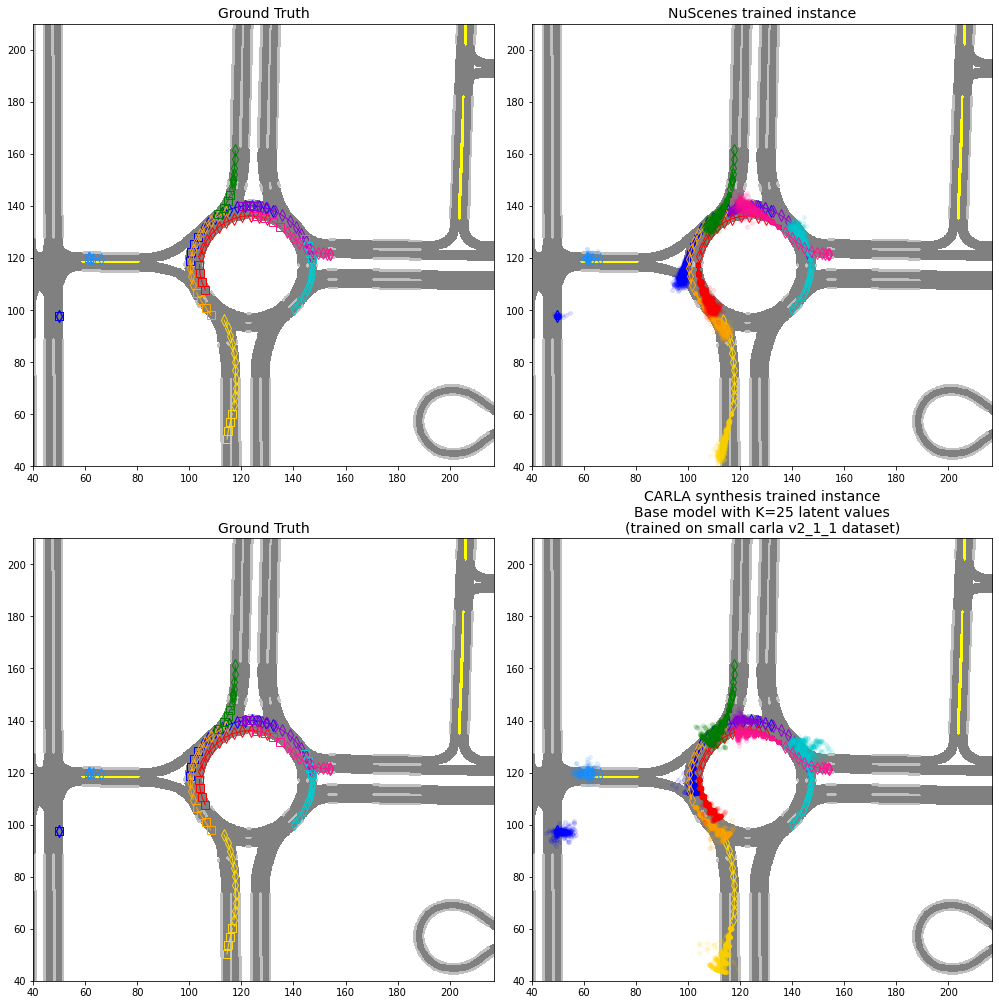

In [11]:
t = 20
timesteps = np.array([t])
scene_idx = 12
scene = carla_scenes[scene_idx]
num_samples = 200
ph = 6
zoom = 40
show_predictions = False
show_gt = True
fig, axes = plt.subplots(2, 2, figsize=(14,14))
axes = axes.ravel()

plot_instance(axes[0], nuscenes_stg, t=t, scene=scene, ph=ph, num_samples=num_samples, zoom=zoom,
              show_predictions=False, show_gt=True,
              title="Ground Truth")
plot_instance(axes[1], nuscenes_stg, t=t, scene=scene, ph=ph, num_samples=num_samples, zoom=zoom,
              show_predictions=True, show_gt=False,
              title="NuScenes trained instance")

plot_instance(axes[2], carla_stg,    t=t, scene=scene, ph=ph, num_samples=num_samples, zoom=zoom,
              show_predictions=False, show_gt=True,
              title="Ground Truth")
plot_instance(axes[3], carla_stg,    t=t, scene=scene, ph=ph, num_samples=num_samples, zoom=zoom,
              show_predictions=True, show_gt=False,
              title=f"CARLA synthesis trained instance\n{carla_model.desc}")

fig.tight_layout()

### Latents to forecasts

### Plot predictions by latent

In [76]:
def generate_vehicle_latents(
            eval_stg,
            num_samples = 200,
            z_mode=False, gmm_mode = False, full_dist = False, all_z_sep = False):
    # Trajectron.predict() arguments
    min_future_timesteps = 0
    min_history_timesteps = 1

    node_type = eval_stg.env.NodeType.VEHICLE
    if node_type not in eval_stg.pred_state:
        raise Exception("fail")

    model = eval_stg.node_models_dict[node_type]

    # Get Input data for node type and given timesteps
    batch = get_timesteps_data(env=eval_stg.env, scene=scene, t=timesteps, node_type=node_type,
                               state=eval_stg.state,
                               pred_state=eval_stg.pred_state, edge_types=model.edge_types,
                               min_ht=min_history_timesteps, max_ht=eval_stg.max_ht,
                               min_ft=min_future_timesteps,
                               max_ft=min_future_timesteps, hyperparams=eval_stg.hyperparams)
    
    # There are no nodes of type present for timestep
    if batch is None:
        raise Exception("fail")

    (first_history_index,
     x_t, y_t, x_st_t, y_st_t,
     neighbors_data_st,
     neighbors_edge_value,
     robot_traj_st_t,
     map), nodes, timesteps_o = batch

    x = x_t.to(eval_stg.device)
    x_st_t = x_st_t.to(eval_stg.device)
    if robot_traj_st_t is not None:
        robot_traj_st_t = robot_traj_st_t.to(eval_stg.device)
    if type(map) == torch.Tensor:
        map = map.to(eval_stg.device)

    # MultimodalGenerativeCVAE.predict() arguments
    inputs = x
    inputs_st = x_st_t
    first_history_indices = first_history_index
    neighbors = neighbors_data_st
    neighbors_edge_value = neighbors_edge_value
    robot = robot_traj_st_t
    prediction_horizon = ph

    mode = ModeKeys.PREDICT

    x, x_nr_t, _, y_r, _, n_s_t0 = model.obtain_encoded_tensors(mode=mode,
                                                               inputs=inputs,
                                                               inputs_st=inputs_st,
                                                               labels=None,
                                                               labels_st=None,
                                                               first_history_indices=first_history_indices,
                                                               neighbors=neighbors,
                                                               neighbors_edge_value=neighbors_edge_value,
                                                               robot=robot,
                                                               map=map)

    model.latent.p_dist = model.p_z_x(mode, x)
    latent_probs = model.latent.get_p_dist_probs() \
            .cpu().detach().numpy()
    latent_probs = np.squeeze(latent_probs)

    z, num_samples, num_components = model.latent.sample_p(num_samples,
                                                          mode,
                                                          most_likely_z=z_mode,
                                                          full_dist=full_dist,
                                                          all_z_sep=all_z_sep)
    
    _, predictions = model.p_y_xz(mode, x, x_nr_t, y_r, n_s_t0, z,
                                            prediction_horizon,
                                            num_samples,
                                            num_components,
                                            gmm_mode)
    z = z.cpu().detach().numpy()
    zz = z
    # z has shape (number of samples, number of vehicles, number of latent values)
    # z[i,j] gives the latent for sample i of vehicle j
#     print(z.shape)
    
    predictions = predictions.cpu().detach().numpy()
    # predictions has shape (number of samples, number of vehicles, prediction horizon, D)
#     print(predictions.shape)

    predictions_dict = dict()
    for i, ts in enumerate(timesteps_o):
        if ts not in predictions_dict.keys():
            predictions_dict[ts] = dict()
        predictions_dict[ts][nodes[i]] = np.transpose(predictions[:, [i]], (1, 0, 2, 3))
    
    z = np.swapaxes(np.argmax(z, axis=-1), 0, 1)
    predictions = np.swapaxes(predictions, 0, 1)
        
    return z, zz, predictions, nodes, predictions_dict, latent_probs

def plot_behavior(scene, z, predictions, nodes):
#     coords = predictions.reshape(-1, 2)
#     x_max, y_max = np.amax(coords, axis=0)
#     x_min, y_min = np.amin(coords, axis=0)
    figwidth  = 20.
#     figheight = figwidth*(13. / 2.)*(y_max - y_min)/(x_max - x_min)
    figheight = figwidth*(13. / 2.)*(scene.y_size)/(scene.x_size)
    
    _, histories_dict, _ = \
            prediction_output_to_trajectories(
                predictions_dict, dt=scene.dt, max_h=10, ph=ph, map=None)
    
    n_vehicles = len(nodes)
    colors = cm.nipy_spectral(np.linspace(0, 1, 25))
    fig, axes = plt.subplots(13, 2,
            figsize=(figwidth, figheight))
    fig.tight_layout()
    
    for behavior in range(0, 25):
        ax = axes[behavior // 2][behavior % 2]
        color = colors[behavior]
        label=f"z = {behavior}"
        for idx, node in enumerate(nodes):
            zn = z[idx]
            pn = predictions[idx]
            mask = zn == behavior
            zn = zn[mask]
            pn = pn[mask]
            player_past = histories_dict[t][node]
            player_past = np.vstack(
                    (player_past, player_past[-1][None] + 5))
            
            ax.plot(player_past[:,0], player_past[:,1],
                    color=AGENT_COLORS[idx % NCOLORS],
                    linewidth=1)
            
            for jdx in range(zn.shape[0]):
                ax.plot(pn[jdx, :, 0], pn[jdx, :, 1],
                        marker='o', color=color,
                        linewidth=1, alpha=0.2, markersize=4,
                        label=label)
                label=None
#         ax.set_xlim([x_min, x_max])
#         ax.set_ylim([y_min, y_max])
        ax.set_xlim([0, scene.x_size])
        ax.set_ylim([0, scene.y_size])
        ax.set_aspect('equal')
        ax.legend(loc='upper right')
        ax.set_facecolor("grey")
#     axes[-1,-1].set_xlim([x_min, x_max])
#     axes[-1,-1].set_ylim([y_min, y_max])
    axes[-1,-1].set_xlim([0, scene.x_size])
    axes[-1,-1].set_ylim([0, scene.y_size])
    axes[-1,-1].set_visible(False)
    return fig, axes

In [79]:
with torch.no_grad():
    z,zz, predictions, nodes, predictions_dict, latent_probs = generate_vehicle_latents(
            nuscenes_stg,
            num_samples=500,
            z_mode=False, gmm_mode = False,
            full_dist = False, all_z_sep = False)

10
VEHICLE/187
VEHICLE/218
VEHICLE/232
VEHICLE/246
VEHICLE/252
VEHICLE/ego
VEHICLE/186
VEHICLE/204
VEHICLE/237
VEHICLE/263


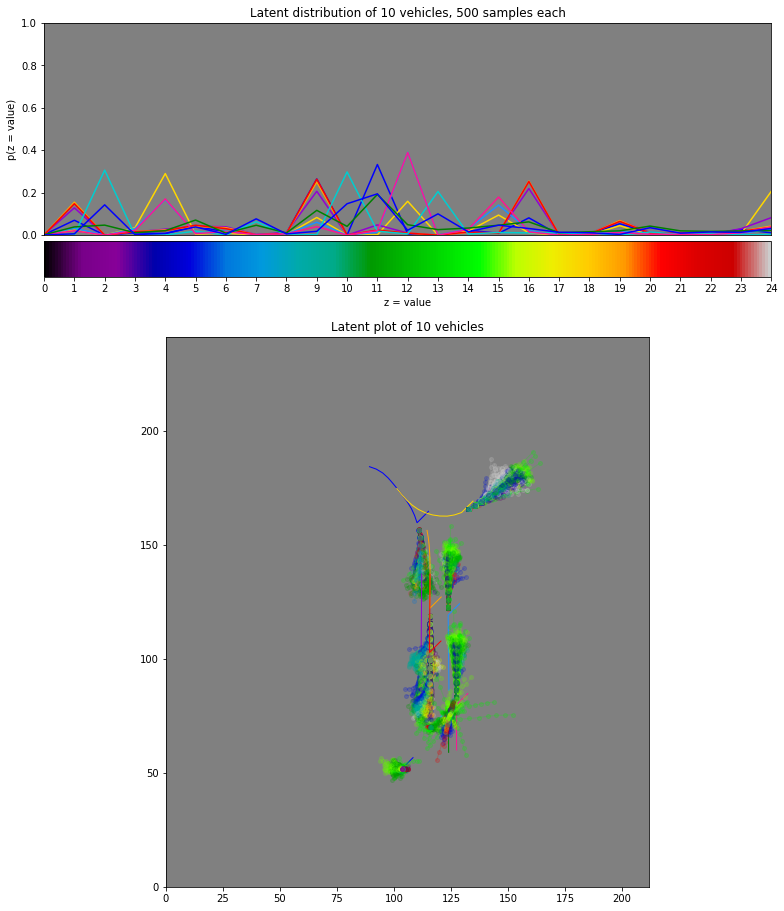

In [80]:
latent_size = zz.shape[2]
latent_colors = cm.nipy_spectral(np.linspace(0, 1, latent_size))
z_counts = np.sum(zz, axis=0) / z.shape[1]
n_vehicles = len(nodes)
print(n_vehicles)

_, histories_dict, _ = \
    prediction_output_to_trajectories(
        predictions_dict, dt=scene.dt, max_h=10, ph=ph, map=None)

fig, (ax1, ax) = plt.subplots(2, 1, figsize=(11, 16))
fig.tight_layout()

ax1.set_facecolor("grey")
for idx, v_probs in enumerate(latent_probs):
    ax1.plot(range(latent_size), v_probs, c=AGENT_COLORS[idx % NCOLORS])
ax1.set_xlim([0, latent_size - 1])
ax1.set_ylim([0, 1])
ax1.set_aspect(7)
ax1.set_ylabel("p(z = value)")
ax1.set_title(f"Latent distribution of {n_vehicles} vehicles, {z.shape[1]} samples each")
ax1.get_xaxis().set_ticks([])

scalarmappaple = cm.ScalarMappable(cmap=cm.nipy_spectral)
scalarmappaple.set_array(range(0, latent_size))
plt.colorbar(scalarmappaple, ax=ax1, orientation='horizontal',
             pad=0.01,
             ticks=range(0, 25),
             label="z = value")

for idx, node in enumerate(nodes):
    print(node)
    player_past = histories_dict[t][node]
    player_past = np.vstack((player_past, player_past[-1][None] + 5))

    ax.plot(player_past[:,0], player_past[:,1],
            color=AGENT_COLORS[idx % NCOLORS],
            linewidth=1)

    # latent variable z corresponding to vehicle.
    zn = z[idx]
    pn = predictions[idx]
    for jdx in range(zn.shape[0]):
        color = latent_colors[zn[jdx]]
        ax.plot(pn[jdx, :, 0], pn[jdx, :, 1],
                marker='o',
                 color=color,
                linewidth=1, alpha=0.2, markersize=4)

ax.set_facecolor("grey")
ax.set_title(f"Latent plot of {n_vehicles} vehicles")
ax.set_aspect('equal')
ax.set_xlim([0, scene.x_size])
ax.set_ylim([0, scene.y_size])
fig.tight_layout()

# fn = f"predict_scene{scene.name}_t{timesteps[0]}_comb_latents.png"
# fp = os.path.join('plots', fn)
# fig.savefig(fp)

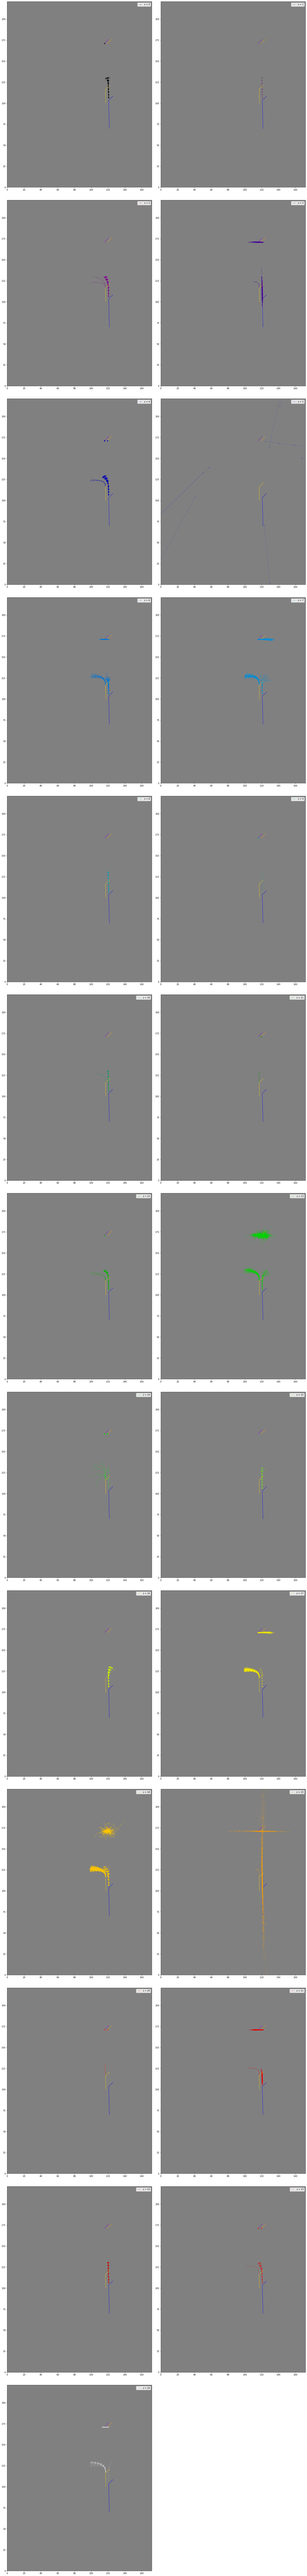

In [11]:
fig, ax = plot_behavior(scene, z, predictions, nodes)
# fn = f"predict_scene{scene.name}_t{timesteps[0]}_each_latents.png"
# fp = os.path.join('plots', fn)
# fig.savefig(fp)